In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from linear_classifier_training import TrainLinearClassifiersFS

In [2]:
data_root = 'data/extracted_features/supervised'



X_train = np.load(f'{data_root}/X_train.npy')
X_val = np.load(f'{data_root}/X_val.npy')
X_test = np.load(f'{data_root}/X_test.npy')

y_train = np.load(f'{data_root}/y_train.npy')
y_val = np.load(f'{data_root}/y_val.npy')
y_test = np.load(f'{data_root}/y_test.npy')

In [3]:
X_train = np.vstack([X_train,X_val])
y_train = np.vstack([np.expand_dims(y_train,axis=1),np.expand_dims(y_val,axis=1)])


In [6]:
svm = LinearSVC(max_iter=5000,
                dual=False,
                class_weight='balanced',
                verbose=2
               )

lr = LogisticRegression(multi_class = 'multinomial',max_iter=5000)


models = {
         'SVM':
          {'model':svm,
          'param_grid':{'C':list(2**np.arange(-19,-3,1,dtype=float))+list(10**np.arange(-7,2,1,dtype=float))}
          },
          
          'LR':
          {'model':lr,
           'param_grid':{'C':10**np.linspace(-6,6,40)}
          }
         }

cv = 3
ns = [
      3,
      4,
      8,
      16,
      32,
      96
    ]
repeats = 5

In [7]:
%%time

tlc = TrainLinearClassifiersFS(X_train,
                                 X_test,
                                 y_train,
                                 y_test,cv)
results = tlc.train_few_shot_models(X_train,
                                   y_train.flatten(),
                                   X_test,
                                   y_test.flatten(),
                                   models,
                                   ns,
                                   repeats = 5)
print(results)

Training with 3 observations per class...
Training SVM...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LibLinear]Best parameter (CV score=0.6000):
{'SVM__C': 1.9073486328125e-06}
Retraining with full training set with optimal hparams...
[LibLinear]Test set accuracy=0.3803:
Training LR...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameter (CV score=0.6000):
{'LR__C': 1e-06}
Retraining with full training set with optimal hparams...
Test set accuracy=0.3803:
Training with 3 observations per class...
Training SVM...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LibLinear]Best parameter (CV score=0.4000):
{'SVM__C': 0.03125}
Retraining with full training set with optimal hparams...
[LibLinear]Test set accuracy=0.3533:
Training LR...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameter (CV score=0.3667):
{'LR__C': 0.0005878016072274912}
Retraining with full training set with optimal hparams...
Test set accurac

In [8]:
clf_report_df = []

for n in ns:
    for r in range(repeats):
        temp = results[r][n]['best_model']['clf_report_df'].T.reset_index()
        temp['n'] = n
        clf_report_df.append(temp)

clf_report_df = pd.concat(clf_report_df)

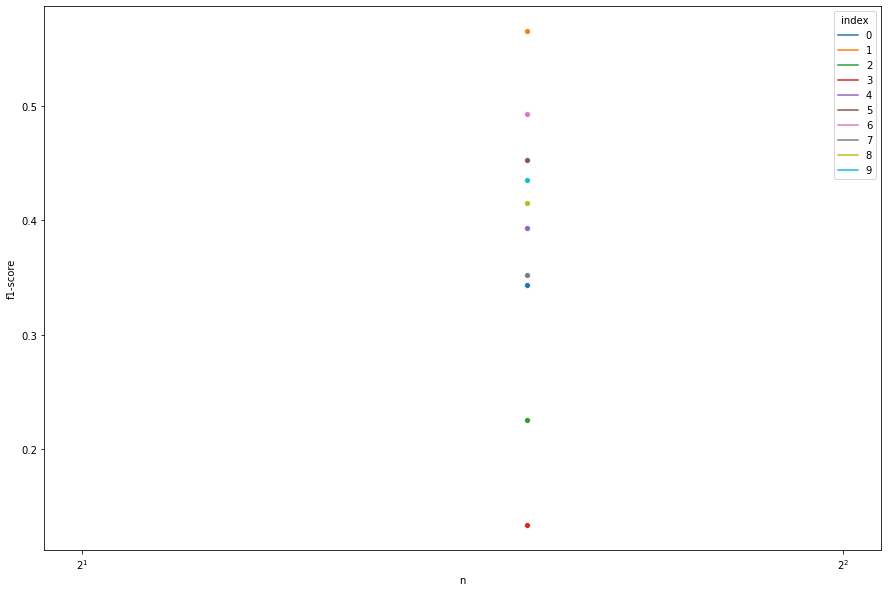

In [17]:
plt.figure(figsize = (15,10))
ax = sns.lineplot(data = clf_report_df,x = 'n',y='f1-score',hue = 'index',ci=None,marker = 'o')
ax.set_xscale('log',base=2)

In [10]:
accs = []
aps = []

for i in tlc.results.keys():
    accs.append([tlc.results[i][n]['best_model']['test_acc']*100 for n in tlc.results[i].keys()])
    aps.append([tlc.results[i][n]['best_model']['test_ap']*100 for n in tlc.results[i].keys()])

In [11]:
results_df_accs = pd.DataFrame([j for i in [list(zip(ns,i)) for i in accs] for j in i],
              columns = ['num_labeled_sampled','acc'])

results_df_maps = pd.DataFrame([j for i in [list(zip(ns,i)) for i in aps] for j in i],
              columns = ['num_labeled_sampled','mAP'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  


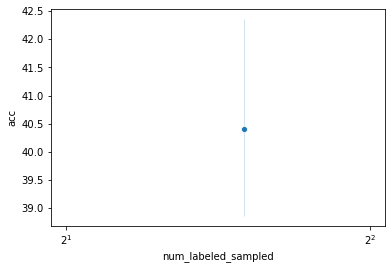

In [12]:
ax = sns.lineplot(x='num_labeled_sampled',y='acc',marker='o',data=results_df_accs)
ax.set_xscale('log',basex=2)